<a href="https://colab.research.google.com/github/BackBencher2424/BA820_Team_14_Project/blob/VG_M2/BA820_M2_Q1_Vishesh_Goyal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**BA820 – Project M2**
**Project Title:** *Code Trends, Quantified: Mapping the Programming Language Ecosystem* <br>
**Section and Team Number:** *B1 Team 14* <br>
**Student Name:** *Vishesh Goyal*

##**Refined Problem Statement & Focus**

###**M1 Question 1:** *Do programming languages naturally cluster into distinct groups based on shared technical features (syntax patterns, file types) and community signals (GitHub activity, Wikipedia view)?*

####**Elaborating Question 1 for M2**
We will be dividing the question into sub questions and making a umbrella-like structure for the questions for easier understanding and better interpretability. We would also be adding the community signals features, `appeared` and `last_activity`, for better interpretation.


##### **Main Question**
Do programming languages form meaningful, stable clusters when combining technical fingerprints (file extensions + GitHub metadata) with community signals (GitHub activity, Wikipedia attention, users/jobs)?

######**Sub Questions**

**Q1.** What clusters emerge from technical fingerprints (extensions + GitHub language metadata), and how interpretable are they?

**Q2.** What clusters emerge from community signals (GitHub/Wikipedia/users/jobs), and do they reflect market segmentation?

**Q3.** Do technical and community clusterings align, or do they reveal mismatches (similar tech, different adoption)? (Deffered to M3)

## **Code**

###**EDA (Extended + Relevant to the specific question)**

####*Setup*

**Load the dataset and confirm its size/columns to understand what can realistically be clustered.**

- The dataset contains 4303 languages and many columns (X_comm later confirms (4303, 49) after selecting community features).
- From M1, many GitHub-language metadata fields (including extensions) are missing for ~89% of rows, so a “technical fingerprint” analysis cannot represent the full dataset.

In [308]:
!pip -q install umap-learn #installs UMAP which is used for visualization (2D embedding).

In [309]:
import re                           # for parsing file-extension tokens
import numpy as np                  # numeric computing
import pandas as pd                 # data loading / wrangling
import warnings

import matplotlib.pyplot as plt     # plotting

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score

from scipy.cluster.hierarchy import linkage, dendrogram

import umap                         # UMAP embedding for visualization

# Make pandas prints nicer
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

# Fix random seeds for reproducibility (important for "stability")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [310]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [311]:
path = '/content/drive/MyDrive/BA820 Unsupervised Machine Learning/Datasets/Project Dataset/languages.csv' # path to csv file
df = pd.read_csv(path)
display(df.head())

,pldb_id,title,description,type,appeared,creators,website,domain_name,domain_name_registered,reference,isbndb,book_count,semantic_scholar,language_rank,github_repo,github_repo_stars,github_repo_forks,github_repo_updated,github_repo_subscribers,github_repo_created,github_repo_description,github_repo_issues,github_repo_first_commit,github_language,github_language_tm_scope,github_language_type,github_language_ace_mode,github_language_file_extensions,github_language_repos,wikipedia,wikipedia_daily_page_views,wikipedia_backlinks_count,wikipedia_summary,wikipedia_page_id,wikipedia_appeared,wikipedia_created,wikipedia_revision_count,wikipedia_related,features_has_comments,features_has_semantic_indentation,features_has_line_comments,line_comment_token,last_activity,number_of_users,number_of_jobs,origin_community,central_package_repository_count,file_type,is_open_source
0,java,Java,NaN,pl,1995,James Gosling,https://oracle.com/java/,NaN,NaN,NaN,400.0,401,37.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Java,source.java,programming,java,java jav,11529980.0,https://en.wikipedia.org/wiki/Java_(programmin...,5242.0,11543.0,Java is a general-purpose computer programming...,15881.0,1995.0,2001.0,7818.0,javascript pizza ada csharp eiffel mesa modula...,True,False,True,//,2022,5550123,85206,Sun Microsystems,NaN,text,NaN
1,javascript,JavaScript,NaN,pl,1995,Brendan Eich,NaN,NaN,NaN,https://www.w3schools.com/js/js_reserved.asp,349.0,351,48.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JavaScript,source.js,programming,javascript,js _js bones cjs es es6 frag gs jake javascrip...,16046489.0,https://en.wikipedia.org/wiki/JavaScript,4264.0,8982.0,"JavaScript (), often abbreviated as JS, is a h...",9845.0,1995.0,2001.0,6131.0,java lua scheme perl self c python awk hyperta...,True,False,True,//,2022,5962666,63993,Netscape,NaN,text,NaN
2,c,C,NaN,pl,1972,Dennis Ritchie,NaN,NaN,NaN,http://www.c4learn.com/c-programming/c-keywords/,78.0,78,19.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,source.c,programming,c_cpp,c cats h idc,2160271.0,https://en.wikipedia.org/wiki/C_(programming_l...,6268.0,10585.0,"C (, as in the letter c) is a general-purpose,...",6021.0,2011.0,2001.0,7316.0,cyclone unified-parallel-c split-c cilk b bcpl...,True,False,True,//,2022,3793768,59919,Bell Labs,0.0,text,NaN
3,python,Python,NaN,pl,1991,Guido van Rossum,https://www.python.org/,python.org,1995.0,https://www.programiz.com/python-programming/k...,339.0,342,52.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Python,source.python,programming,python,py cgi fcgi gyp gypi lmi py3 pyde pyi pyp pyt ...,9300725.0,https://en.wikipedia.org/wiki/Python_(programm...,7204.0,6849.0,Python is a widely used high-level programming...,23862.0,1991.0,2001.0,6342.0,jython micropython stackless-python cython abc...,True,True,True,#,2022,2818037,46976,Centrum Wiskunde & Informatica,NaN,text,NaN
4,sql,SQL,NaN,queryLanguage,1974,Donald D. Chamberlin and Raymond F. Boyce,NaN,NaN,NaN,NaN,177.0,182,37.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SQL,source.sql,data,sql,sql cql ddl inc mysql prc tab udf viw,1222.0,https://en.wikipedia.org/wiki/SQL,3084.0,4159.0,SQL ( ( listen) ESS-kew-EL or ( listen) SEE-k...,29004.0,1986.0,2001.0,4153.0,sql-92 datalog linq powershell c sql-psm sqlpl...,True,False,True,--,2022,7179119,219617,IBM,0.0,text,NaN


In [312]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4303 entries, 0 to 4302
Data columns (total 49 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   pldb_id                            4303 non-null   object 
 1   title                              4303 non-null   object 
 2   description                        823 non-null    object 
 3   type                               4303 non-null   object 
 4   appeared                           4303 non-null   int64  
 5   creators                           1100 non-null   object 
 6   website                            1375 non-null   object 
 7   domain_name                        715 non-null    object 
 8   domain_name_registered             502 non-null    float64
 9   reference                          1989 non-null   object 
 10  isbndb                             1086 non-null   float64
 11  book_count                         4303 non-null   int64

####*Preprocessing*

**Clean and prepare variables so clustering is not dominated by missing values or incompatible data types.**
- From M1, we learned we cannot drop columns simply because they are missing - languages are diverse and many fields are structurally sparse.
- Numeric conversion + imputation is necessary so clustering can run without errors and so distances are comparable.

In [313]:
df.columns.tolist()     #converting all the alavilable columns names to list
df.columns              #displaying which columns are available

Index(['pldb_id', 'title', 'description', 'type', 'appeared', 'creators', 'website', 'domain_name', 'domain_name_registered', 'reference',
       'isbndb', 'book_count', 'semantic_scholar', 'language_rank', 'github_repo', 'github_repo_stars', 'github_repo_forks',
       'github_repo_updated', 'github_repo_subscribers', 'github_repo_created', 'github_repo_description', 'github_repo_issues',
       'github_repo_first_commit', 'github_language', 'github_language_tm_scope', 'github_language_type', 'github_language_ace_mode',
       'github_language_file_extensions', 'github_language_repos', 'wikipedia', 'wikipedia_daily_page_views', 'wikipedia_backlinks_count',
       'wikipedia_summary', 'wikipedia_page_id', 'wikipedia_appeared', 'wikipedia_created', 'wikipedia_revision_count',
       'wikipedia_related', 'features_has_comments', 'features_has_semantic_indentation', 'features_has_line_comments',
       'line_comment_token', 'last_activity', 'number_of_users', 'number_of_jobs', 'origin_com

In [314]:
#Keeping the columns that we are actually interested in
candidate_cols = [
    # identifiers
    "title", "type", "file_type",
    # time
    "appeared", "last_activity",
    # GitHub language metadata (technical)
    "github_language_type", "github_language_tm_scope", "github_language_ace_mode",
    "github_language_file_extensions",
    # GitHub activity (community-ish)
    "github_language_repos", "github_repo_stars", "github_repo_forks",
    # Wikipedia attention
    "wikipedia_daily_page_views", "wikipedia_backlinks_count", "wikipedia_revision_count",
    # adoption / demand
    "number_of_users", "number_of_jobs",
]

#making sure that we have all the columns that are availale
candidate_cols = [c for c in candidate_cols if c in df.columns]

In [315]:
#checking the missing rate, i.e. how many values are missing in the each colums by total values
missing_rate = df[candidate_cols].isna().mean().sort_values()
missing_rate.to_frame("missing_rate").head(25)

,missing_rate
title,0.000000
type,0.000000
appeared,0.000000
last_activity,0.000000
number_of_users,0.000000
number_of_jobs,0.000000
wikipedia_daily_page_views,0.659307
wikipedia_backlinks_count,0.668603
wikipedia_revision_count,0.727399
file_type,0.746688


In [316]:
n_total = len(df)
n_with_ext = df["github_language_file_extensions"].notna().sum()        #number fo languages that have extensions mentioned in the github column

print("Total languages:", n_total)
print("Languages with github_language_file_extensions:", n_with_ext)
print("Percent with extensions:", round(100 * n_with_ext / n_total, 2), "%")

Total languages: 4303
Languages with github_language_file_extensions: 470
Percent with extensions: 10.92 %


#####*Checking for Skewness, because highly skewed features would impact the clustering distances. We would be using `log1p` to reduce the Skewness so that the outliers have the minimum impact on clustering.*

**Check if popularity variables are long-tailed and apply log1p so outliers don’t dominate distance calculations.**
- In M1, GitHub stars and Wikipedia views were clearly skewed (we used log scaling in plots).
- M1 also highlighted extreme outliers in Jobs vs Users (e.g., HTTP and SQL), proving raw-scale clustering would be biased toward a few huge languages.
- M2 uses log1p so large values are compressed (e.g., 1,000,000 doesn’t “swamp” smaller languages).

In [317]:
#These community metrics are strongly right-skewed (mean ≫ median and extreme maxima), so we apply log1p() and standardization to prevent a few highly popular languages from dominating distance-based clustering.

skew_cols = ["number_of_users", "number_of_jobs", "wikipedia_daily_page_views", "github_repo_stars"]
skew_cols = [c for c in skew_cols if c in df.columns]

df[skew_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
number_of_users,4303.0,13771.264467,227712.946798,0.0,0.0,20.0,230.0,7179119.0
number_of_jobs,4303.0,422.183825,12572.985441,0.0,0.0,0.0,0.0,771996.0
wikipedia_daily_page_views,1466.0,227.133015,783.552400,-1.0,9.0,24.0,99.0,13394.0
github_repo_stars,889.0,2127.402700,7554.016422,0.0,29.0,194.0,1071.0,88526.0


In [318]:
df[skew_cols].skew(numeric_only=True) #values >>1 confirms heavy right skewness

,0
number_of_users,22.601737
number_of_jobs,55.224695
wikipedia_daily_page_views,8.000938
github_repo_stars,7.384292


#####*Computing Feature Sets*

**Split into two feature sets to match the sub-questions and handle missingness correctly.**

- M1 missingness table showed github_language_file_extensions is missing for 3833 rows (~89.08%).
- Therefore in M2 we created:
    - Feature Set A (Technical): only languages with extension fingerprints (470 languages)
    - Feature Set B (Community): the full dataset (4303 languages)

- Interpretation: this avoids “pretending” technical fingerprints exist when they don’t.

In [319]:
#Technical Fingerprints Dataset

df_tech = df[df["github_language_file_extensions"].notna()].copy()

print("Technical subset shape:", df_tech.shape)
df_tech[["title", "github_language_file_extensions", "github_language_type"]].head(10)


Technical subset shape: (470, 49)


,title,github_language_file_extensions,github_language_type
0,Java,java jav,programming
1,JavaScript,js _js bones cjs es es6 frag gs jake javascrip...,programming
2,C,c cats h idc,programming
3,Python,py cgi fcgi gyp gypi lmi py3 pyde pyi pyp pyt ...,programming
4,SQL,sql cql ddl inc mysql prc tab udf viw,data
5,C++,cpp c++ cc cp cxx h h++ hh hpp hxx inc inl ino...,programming
6,HTML,html hta htm htmlhl inc xht xhtml,markup
7,XML,xml adml admx ant axaml axml builds ccproj ccx...,data
8,PHP,php aw ctp fcgi inc php3 php4 php5 phps phpt,programming
9,Perl,pl al cgi fcgi perl ph plx pm psgi t,programming


In [320]:
#Full dataset for comunity only clustering
df_full = df.copy()
print("Full dataset shape:", df_full.shape)

Full dataset shape: (4303, 49)


#####*Helper Functions*

**Utility functions for safe numeric conversion, log transforms, and parsing extension strings into tokens.**

- These functions ensure reproducibility and prevent common beginner errors (non-numeric strings, NaNs, inconsistent extension formatting).
- Extension parsing matters because technical fingerprints depend on consistent tokenization (e.g., .py .pyi → ["py","pyi"]).

In [321]:
# Converts Columns to Numbers
def to_numeric(series: pd.Series) -> pd.Series:
    return pd.to_numeric(series, errors="coerce")

# Log-transform helper (log1p works even when value = 0)
def add_log1p(df_in: pd.DataFrame, col: str) -> str:
    # Create a new column name like "log1p_number_of_users"
    new_col = f"log1p_{col}"
    # Fill NaN with 0 BEFORE log, because log(undefined) is not valid
    df_in[new_col] = np.log1p(df_in[col].fillna(0))
    return new_col

# Parse extension strings like: ".py .pyw .pyi" -> ["py", "pyw", "pyi"]
def parse_extensions(ext_str: str) -> list[str]:
    if pd.isna(ext_str) or not isinstance(ext_str, str):
        return []
    tokens = ext_str.strip().lower().split()            # split on spaces
    clean = []
    for t in tokens:
        t = t.strip()
        # keep letters/numbers/+/-/_ only (so c++ becomes c++)
        t = re.sub(r"[^a-z0-9_\+\-]", "", t)
        if 1 <= len(t) <= 12:
            clean.append(t)
    return clean

# Turn token into a safe column name
def safe_ext_col(token: str) -> str:
    return "ext_" + re.sub(r"[^a-z0-9]+", "_", token.lower()).strip("_")

###**Clustering**

####*Feature Set A (Technical Fingerprints)*

#####*Setup for Clustering*

In this section we build a numeric matrix `X_tech` suitable for clustering.

Features included:
- **Extension fingerprint one-hots** (top N most common extensions in the technical subset)
- GitHub language metadata categorical fields (one-hot)
- Community signals (log1p users/jobs/wiki/etc.)
- Simple time signals (appeared, last_activity)

Then we:
- impute missing numeric values with median
- standardize numeric features
- one-hot encode categorical features

In [322]:
#cleaning columns
#selecting numerical colums
numeric_base_cols = [
    "appeared", "last_activity",
    "number_of_users", "number_of_jobs",
    "wikipedia_daily_page_views", "wikipedia_backlinks_count", "wikipedia_revision_count",
    "github_language_repos", "github_repo_stars", "github_repo_forks",
]

# Convert to numeric if column exists
for c in numeric_base_cols:
    if c in df_tech.columns:
        df_tech[c] = to_numeric(df_tech[c])

# Wikipedia views sometimes uses negative placeholders -> treat as missing and impute with nan
if "wikipedia_daily_page_views" in df_tech.columns:
    df_tech.loc[df_tech["wikipedia_daily_page_views"] < 0, "wikipedia_daily_page_views"] = np.nan

# Basic sanity: out-of-range years -> NaN
for yc in ["appeared", "last_activity"]:
    if yc in df_tech.columns:
        df_tech.loc[(df_tech[yc] < 1800) | (df_tech[yc] > 2100), yc] = np.nan

df_tech[numeric_base_cols].head(5)

,appeared,last_activity,number_of_users,number_of_jobs,wikipedia_daily_page_views,wikipedia_backlinks_count,wikipedia_revision_count,github_language_repos,github_repo_stars,github_repo_forks
0,1995.0,2022.0,5550123,85206,5242.0,11543.0,7818.0,11529980.0,NaN,NaN
1,1995.0,2022.0,5962666,63993,4264.0,8982.0,6131.0,16046489.0,NaN,NaN
2,1972.0,2022.0,3793768,59919,6268.0,10585.0,7316.0,2160271.0,NaN,NaN
3,1991.0,2022.0,2818037,46976,7204.0,6849.0,6342.0,9300725.0,NaN,NaN
4,1974.0,2022.0,7179119,219617,3084.0,4159.0,4153.0,1222.0,NaN,NaN


In [323]:
#creating new columns which contains log1p values of the original columns in df_tech
log_cols = []
for c in [
    "number_of_users", "number_of_jobs",
    "wikipedia_daily_page_views", "wikipedia_backlinks_count", "wikipedia_revision_count",
    "github_language_repos", "github_repo_stars", "github_repo_forks",
]:
    if c in df_tech.columns:
        log_cols.append(add_log1p(df_tech, c))

print("Created log columns:", log_cols)
df_tech[log_cols].head(5)


Created log columns: ['log1p_number_of_users', 'log1p_number_of_jobs', 'log1p_wikipedia_daily_page_views', 'log1p_wikipedia_backlinks_count', 'log1p_wikipedia_revision_count', 'log1p_github_language_repos', 'log1p_github_repo_stars', 'log1p_github_repo_forks']


,log1p_number_of_users,log1p_number_of_jobs,log1p_wikipedia_daily_page_views,log1p_wikipedia_backlinks_count,log1p_wikipedia_revision_count,log1p_github_language_repos,log1p_github_repo_stars,log1p_github_repo_forks
0,15.529331,11.352839,8.564649,9.353921,8.964312,16.260461,0.0,0.0
1,15.601028,11.066545,8.358197,9.103089,8.721276,16.591001,0.0,0.0
2,15.148871,11.000766,8.743372,9.267288,8.897956,14.585745,0.0,0.0
3,14.851551,10.757413,8.882531,8.832004,8.755107,16.045603,0.0,0.0
4,15.786687,12.299645,8.034307,8.333270,8.331827,7.109062,0.0,0.0


In [324]:
### Standerdizing and One hot encoding the extensions that is listed for languages in the column "github_language_file_extensions"

TOP_N_EXT = 60

# Parse extension tokens for every row
ext_tokens = df_tech["github_language_file_extensions"].apply(parse_extensions)

# Count token frequencies
token_counts = pd.Series([t for row in ext_tokens for t in row]).value_counts()

# Choose most common tokens
top_tokens = token_counts.head(TOP_N_EXT).index.tolist()
top_cols = [safe_ext_col(t) for t in top_tokens]

# Build a 0/1 matrix (rows x top_tokens)
ext_matrix = np.zeros((len(df_tech), len(top_tokens)), dtype=int)
token_to_idx = {t: i for i, t in enumerate(top_tokens)}

# Convert each row's token list into a set, then fill matrix
for i, token_list in enumerate(ext_tokens):
    token_set = set(token_list)
    for t in token_set:
        j = token_to_idx.get(t)
        if j is not None:
            ext_matrix[i, j] = 1

df_ext = pd.DataFrame(ext_matrix, columns=top_cols, index=df_tech.index)

# Add a simple numeric feature: how many extensions are listed?
df_tech["num_extensions_listed"] = ext_tokens.apply(lambda x: len(set(x)))

print("Extension one-hot matrix shape:", df_ext.shape)
df_ext.head()

Extension one-hot matrix shape: (470, 60)


,ext_inc,ext_m,ext_fcgi,ext_cls,ext_t,ext_l,ext_fs,ext_pro,ext_pm,ext_sql,ext_gs,ext_pl,ext_v,ext_ms,ext_bf,ext_d,ext_cl,ext_e,ext_bas,ext_f,ext_bb,ext_rs,ext_cgi,ext_mod,ext_for,ext_h,ext_w,ext_jsx,ext_jq,ext_m4,ext_asc,ext_rno,ext_shader,ext_g,ext_q,ext_gd,ext_pwn,ext_prc,ext_cp,ext_n,ext_tst,ext_ch,ext_moo,ext_6pl,ext_6pm,ext_p6m,ext_nqp,ext_p6,ext_p6l,ext_pm6,ext_pl6,ext_spec,ext_rpy,ext_ecl,ext_j,ext_properties,ext_p,ext_rhtml,ext_ls,ext_lsp
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [325]:
# Selecting Categorical Columns for Tech Clustering

cat_cols_tech = []
for c in ["type", "file_type", "github_language_type", "github_language_tm_scope", "github_language_ace_mode"]:
    if c in df_tech.columns:
        cat_cols_tech.append(c)

print("Categorical columns (tech):", cat_cols_tech)

Categorical columns (tech): ['type', 'file_type', 'github_language_type', 'github_language_tm_scope', 'github_language_ace_mode']


In [326]:
#combining and making the final X_tech matrix

# Combine engineered extension features into one table
df_model_tech = pd.concat([df_tech, df_ext], axis=1)

# Numeric columns for clustering (use log versions + time + num_extensions_listed)
num_cols_tech = ["appeared", "last_activity", "num_extensions_listed"] + log_cols
num_cols_tech = [c for c in num_cols_tech if c in df_model_tech.columns]  # defensive

print("Numeric columns (tech):", num_cols_tech)
print("Extension columns used:", len(top_cols))

# ColumnTransformer:
# - numeric: impute median + standardize
# - categorical: impute most frequent + one-hot encode
# - extension one-hots: pass through (already 0/1)
preprocess_tech = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]), num_cols_tech),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]), cat_cols_tech),
        ("ext", "passthrough", top_cols),
    ],
    remainder="drop",
)

# Fit + transform to numeric matrix
X_tech = preprocess_tech.fit_transform(df_model_tech)

print("Final X_tech shape:", X_tech.shape)

Numeric columns (tech): ['appeared', 'last_activity', 'num_extensions_listed', 'log1p_number_of_users', 'log1p_number_of_jobs', 'log1p_wikipedia_daily_page_views', 'log1p_wikipedia_backlinks_count', 'log1p_wikipedia_revision_count', 'log1p_github_language_repos', 'log1p_github_repo_stars', 'log1p_github_repo_forks']
Extension columns used: 60
Final X_tech shape: (470, 554)


#####*Visualising*

######*PCA*

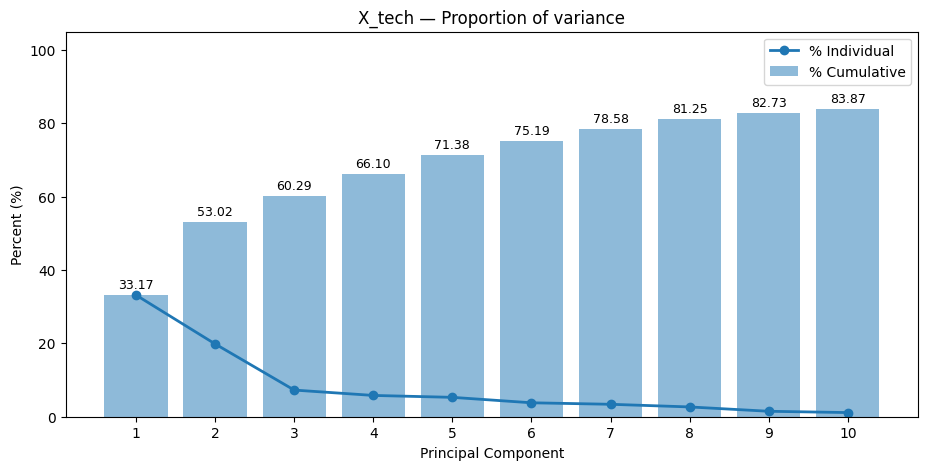

In [357]:
# Make dense if needed (PCA needs dense)
X_tech_dense = X_tech.toarray() if hasattr(X_tech, "toarray") else X_tech

# Fit PCA
pca_tech = PCA(random_state=RANDOM_STATE)
pca_tech.fit(X_tech_dense)

# Choose how many PCs to show (like your example: 10)
n_show = 10
var_ratio = pca_tech.explained_variance_ratio_[:n_show] * 100          # % individual
cum_ratio = np.cumsum(var_ratio)                                       # % cumulative

pcs = np.arange(1, n_show + 1)

plt.figure(figsize=(11, 5))

# Cumulative bars (grey)
plt.bar(pcs, cum_ratio, alpha=0.5, label="% Cumulative")

# Individual line (black) with markers
plt.plot(pcs, var_ratio, marker="o", linewidth=2, label="% Individual")

# Optional: label cumulative values on top of bars
for x, y in zip(pcs, cum_ratio):
    plt.text(x, y + 1, f"{y:.2f}", ha="center", va="bottom", fontsize=9)

# Titles + labels
plt.title("X_tech — Proportion of variance")
plt.xlabel("Principal Component")
plt.ylabel("Percent (%)")
plt.ylim(0, 105)
plt.xticks(pcs)
plt.legend()
plt.show()

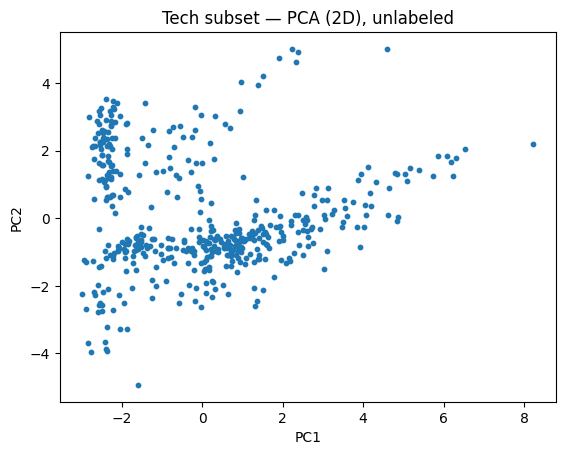

Explained variance ratio (PC1, PC2): [0.33174927 0.19848683]
Total variance explained by PC1+PC2: 0.5302361020009727


In [373]:
# PCA 2D
pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
X_tech_pca2 = pca2.fit_transform(X_tech.toarray() if hasattr(X_tech, "toarray") else X_tech)

plt.figure()
plt.scatter(X_tech_pca2[:, 0], X_tech_pca2[:, 1], s=10)
plt.title("Tech subset — PCA (2D), unlabeled")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

print("Explained variance ratio (PC1, PC2):", pca2.explained_variance_ratio_)
print("Total variance explained by PC1+PC2:", pca2.explained_variance_ratio_.sum())

- I used PCA with 2 components because it gives a simple, readable 2D picture of how languages spread out based on the features, which is great for quick visual inspection and reporting.
- For X_tech, PC1 (~33.17%) + PC2 (\~19.85%) explain ~53.02% of the total variance, so the 2D plot captures a majority of the structure without becoming hard to interpret.
- The scree (variance) plot supports this choice because variance drops sharply after the first few components, meaning the first two carry the most information.
- Even though 2 PCs don’t capture everything, they are a good trade-off between interpretability and information retained, and UMAP is used alongside PCA when we want a richer view of structure.

######*UMAP*

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


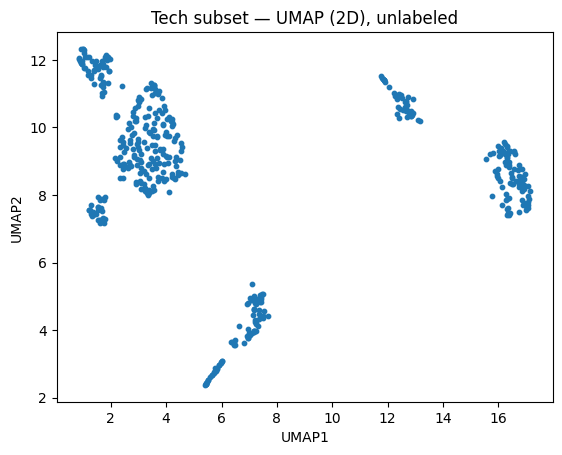

In [328]:
# UMAP 2D
umap2 = umap.UMAP(
    n_neighbors=20,          # controls local vs global structure
    min_dist=0.05,           # lower -> tighter clusters in visualization
    n_components=2,
    random_state=RANDOM_STATE
)

# UMAP needs a dense array in some environments; handle safely
X_tech_dense = X_tech.toarray() if hasattr(X_tech, "toarray") else X_tech
X_tech_umap2 = umap2.fit_transform(X_tech_dense)

plt.figure()
plt.scatter(X_tech_umap2[:, 0], X_tech_umap2[:, 1], s=10)
plt.title("Tech subset — UMAP (2D), unlabeled")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()

- The UMAP plot for X_tech shows several clearly separated “islands”, meaning the technical features (extension fingerprints + GitHub metadata) naturally form distinct groups. Points that are close together represent languages with similar extension patterns/metadata, while the large gaps suggest groups that are meaningfully different (and may include outliers).
- PCA is linear, so it mainly preserves broad/global variance and can “smear” curved or non-linear structure; UMAP is non-linear, so it often gives cleaner visual separation for clustering—even when the real separation happens in complex, high-dimensional patterns like sparse one-hot extensions.

#####*K Means Clustering on X_Tech*

We choose **k** using silhouette score over the full `X_Tech` matrix

In [329]:
# Trying k from 2..10 and compute silhouette
k_values = list(range(2, 11))
sil_scores = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(X_tech)
    score = silhouette_score(X_tech, labels)   # silhouette on high-dimensional X
    sil_scores.append(score)

results_k = pd.DataFrame({"k": k_values, "silhouette": sil_scores})
results_k

,k,silhouette
0,2,0.218743
1,3,0.226929
2,4,0.238310
3,5,0.239078
4,6,0.212925
5,7,0.213933
6,8,0.174662
7,9,0.167286
8,10,0.183190


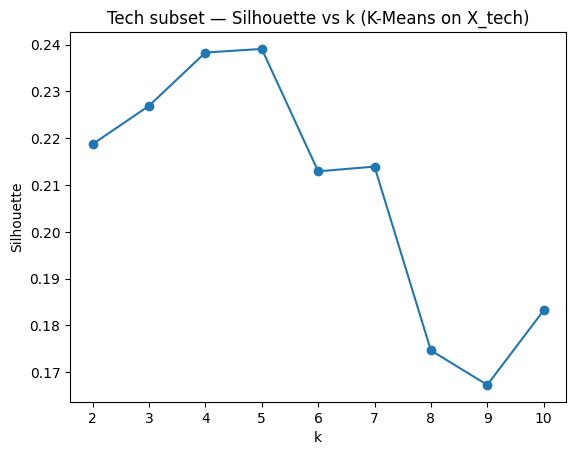

Best k (tech subset): 5


In [330]:
# Plot silhouette scores
plt.figure()
plt.plot(results_k["k"], results_k["silhouette"], marker="o")
plt.title("Tech subset — Silhouette vs k (K-Means on X_tech)")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.show()

best_k_tech = int(results_k.loc[results_k["silhouette"].idxmax(), "k"])
print("Best k (tech subset):", best_k_tech)

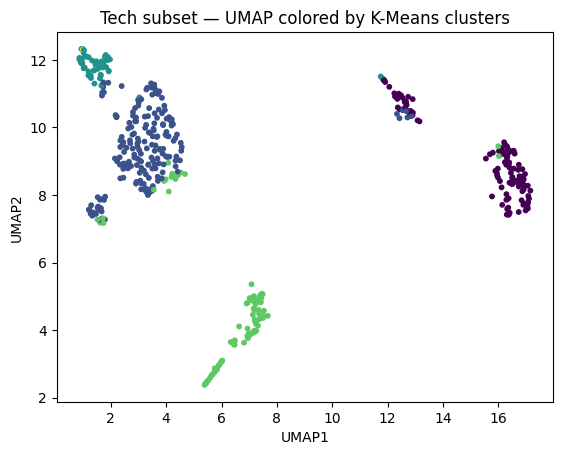

,title,cluster_kmeans_tech
0,Java,2
1,JavaScript,2
2,C,2
3,Python,2
4,SQL,2
5,C++,2
6,HTML,2
7,XML,4
8,PHP,2
9,Perl,2


In [331]:
# Fit final K-Means with best k
kmeans_tech = KMeans(n_clusters=best_k_tech, random_state=RANDOM_STATE, n_init=10)
labels_km_tech = kmeans_tech.fit_predict(X_tech)

# Plot clusters on UMAP
plt.figure()
plt.scatter(X_tech_umap2[:, 0], X_tech_umap2[:, 1], c=labels_km_tech, s=10)
plt.title("Tech subset — UMAP colored by K-Means clusters")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()

# Attach labels back to data
df_model_tech = df_model_tech.copy()
df_model_tech["cluster_kmeans_tech"] = labels_km_tech

df_model_tech[["title", "cluster_kmeans_tech"]].head(10)

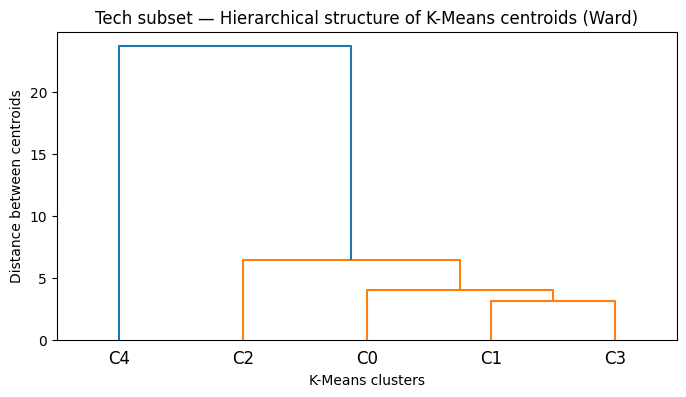

In [351]:
# kmeans_tech must already be fitted
centroids = kmeans_tech.cluster_centers_

Zc = linkage(centroids, method="ward")

plt.figure(figsize=(8, 4))
dendrogram(Zc, labels=[f"C{i}" for i in range(centroids.shape[0])])
plt.title("Tech subset — Hierarchical structure of K-Means centroids (Ward)")
plt.xlabel("K-Means clusters")
plt.ylabel("Distance between centroids")
plt.show()

This plot compares how close the K-Means clusters are to each other. C1 and C3 merge first (most similar centroids), then they join C0, and later C2—so those four clusters form a related “family.” C4 joins only at a much higher distance, meaning it is the most distinct cluster (an outlier-style cluster compared to the others).

#####*Hierarchical Clustering on X_Tech*

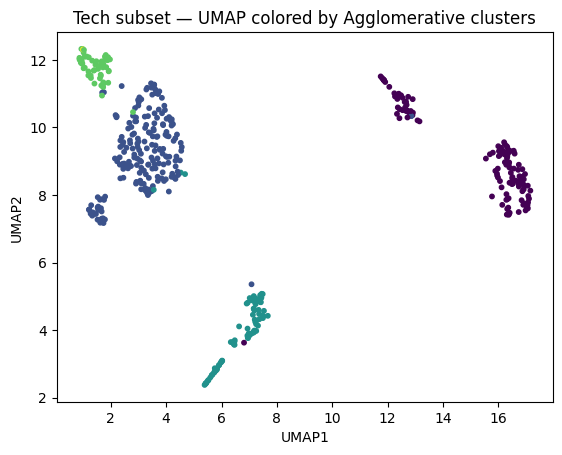

,title,cluster_kmeans_tech,cluster_agglom_tech
0,Java,2,3
1,JavaScript,2,3
2,C,2,3
3,Python,2,3
4,SQL,2,3
5,C++,2,3
6,HTML,2,3
7,XML,4,4
8,PHP,2,0
9,Perl,2,3


In [332]:
# AgglomerativeClustering requires dense input
X_tech_dense = X_tech.toarray() if hasattr(X_tech, "toarray") else X_tech

agg_tech = AgglomerativeClustering(n_clusters=best_k_tech, linkage="ward")
labels_ag_tech = agg_tech.fit_predict(X_tech_dense)

# Plot clusters on UMAP
plt.figure()
plt.scatter(X_tech_umap2[:, 0], X_tech_umap2[:, 1], c=labels_ag_tech, s=10)
plt.title("Tech subset — UMAP colored by Agglomerative clusters")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()

df_model_tech["cluster_agglom_tech"] = labels_ag_tech
df_model_tech[["title", "cluster_kmeans_tech", "cluster_agglom_tech"]].head(10)

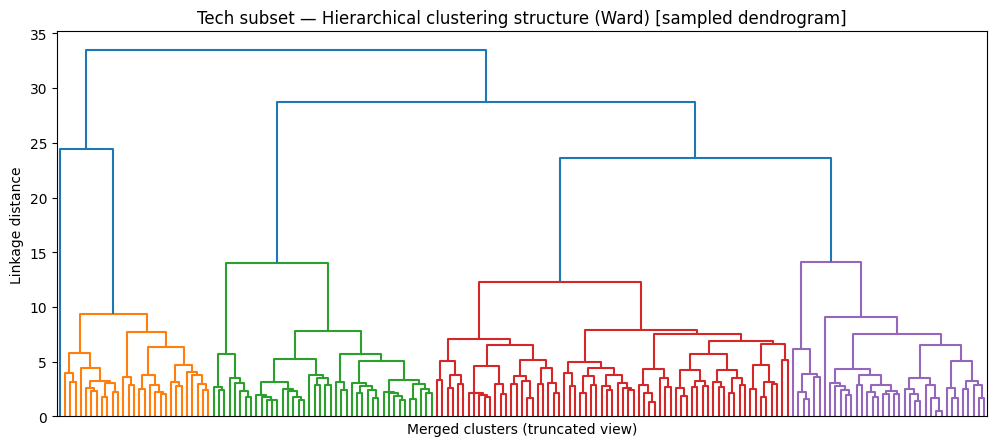

In [333]:
# Make sure we have a dense matrix for scipy
X_tech_dense = X_tech.toarray() if hasattr(X_tech, "toarray") else X_tech

# Sample rows (change sample_size to 150–250 depending on your laptop)
rng = np.random.RandomState(RANDOM_STATE)
sample_size = 200
idx = rng.choice(X_tech_dense.shape[0], size=min(sample_size, X_tech_dense.shape[0]), replace=False)

X_sample = X_tech_dense[idx]

# Ward linkage (matches your AgglomerativeClustering with linkage="ward")
Z = linkage(X_sample, method="ward")

plt.figure(figsize=(12, 5))
dendrogram(Z, truncate_mode="level", p=10, no_labels=True)  # truncate keeps it readable
plt.title("Tech subset — Hierarchical clustering structure (Ward) [sampled dendrogram]")
plt.xlabel("Merged clusters (truncated view)")
plt.ylabel("Linkage distance")
plt.show()

The dendrogram shows several big jumps in linkage distance near the top, meaning the technical subset has a few well-separated groups rather than one smooth continuum. The colored blocks at lower distances indicate tight subgroups, and the large merges above ~25–30 suggest those groups only combine at high “difference,” supporting meaningful cluster structure.

#####*Compairing K Means & Hierarchical Clustering*

In [334]:
ari_methods = adjusted_rand_score(labels_km_tech, labels_ag_tech)
print("ARI (K-Means vs Agglomerative) on tech subset:", round(ari_methods, 4))

ARI (K-Means vs Agglomerative) on tech subset: 0.8112


#####*Interpreting the Clusters*

In [335]:
# Cluster sizes
cluster_sizes = df_model_tech["cluster_kmeans_tech"].value_counts().sort_index()
cluster_sizes.to_frame("size")

,size
cluster_kmeans_tech,
0,120
1,196
2,50
3,103
4,1


In [336]:
# Numeric medians by cluster (log columns + time + num_extensions_listed)
summary_num_cols = ["appeared", "last_activity", "num_extensions_listed"] + log_cols
summary_num_cols = [c for c in summary_num_cols if c in df_model_tech.columns]

cluster_numeric = df_model_tech.groupby("cluster_kmeans_tech")[summary_num_cols].median().round(3)
cluster_numeric

,appeared,last_activity,num_extensions_listed,log1p_number_of_users,log1p_number_of_jobs,log1p_wikipedia_daily_page_views,log1p_wikipedia_backlinks_count,log1p_wikipedia_revision_count,log1p_github_language_repos,log1p_github_repo_stars,log1p_github_repo_forks
cluster_kmeans_tech,,,,,,,,,,,
0,2012.0,2022.0,1.0,8.121,0.000,0.000,0.000,0.000,5.693,7.744,5.396
1,1997.5,2018.0,1.5,6.577,0.000,4.590,4.569,5.563,6.649,0.000,0.000
2,1991.0,2022.0,4.0,11.811,8.188,7.110,7.124,7.482,12.016,0.000,0.000
3,2006.0,2017.0,1.0,5.303,0.000,0.000,0.000,0.000,5.112,0.000,0.000
4,1996.0,2022.0,102.0,14.467,10.652,7.959,8.602,8.301,8.089,0.000,0.000


In [337]:
# Categorical mode (most common value) by cluster
def mode_or_nan(s: pd.Series):
    s = s.dropna()
    if len(s) == 0:
        return np.nan
    return s.value_counts().index[0]

cluster_cats = df_model_tech.groupby("cluster_kmeans_tech")[cat_cols_tech].agg(mode_or_nan)
cluster_cats

,type,file_type,github_language_type,github_language_tm_scope,github_language_ace_mode
cluster_kmeans_tech,,,,,
0,pl,text,programming,none,text
1,pl,text,programming,none,text
2,pl,text,programming,source.vbnet,text
3,pl,text,programming,none,text
4,dataNotation,text,data,text.xml,xml


In [338]:
# Top extension signals per cluster
ext_cols = top_cols  # extension one-hot columns

top_ext_by_cluster = {}
for cl in sorted(df_model_tech["cluster_kmeans_tech"].unique()):
    # mean presence = proportion of languages in this cluster that have this extension token
    means = df_model_tech[df_model_tech["cluster_kmeans_tech"] == cl][ext_cols].mean().sort_values(ascending=False)
    top_ext_by_cluster[cl] = means.head(5)

for cl, top10 in top_ext_by_cluster.items():
    print(f"\nCluster {cl} — top extension signals:")
    display(top10.to_frame("mean_presence"))


Cluster 0 — top extension signals:


,mean_presence
ext_inc,0.025000
ext_bf,0.016667
ext_t,0.008333
ext_cls,0.008333
ext_v,0.008333



Cluster 1 — top extension signals:


,mean_presence
ext_m,0.015306
ext_pro,0.015306
ext_fs,0.015306
ext_l,0.015306
ext_gs,0.015306



Cluster 2 — top extension signals:


,mean_presence
ext_inc,0.12
ext_fcgi,0.12
ext_m,0.06
ext_h,0.06
ext_cgi,0.06



Cluster 3 — top extension signals:


,mean_presence
ext_pm,0.019417
ext_ms,0.019417
ext_rno,0.019417
ext_cls,0.009709
ext_pl,0.009709



Cluster 4 — top extension signals:


,mean_presence
ext_rs,1.0
ext_mod,1.0
ext_inc,0.0
ext_m,0.0
ext_t,0.0


In [339]:
# Example languages per cluster (first 15 alphabetically)
for cl in sorted(df_model_tech["cluster_kmeans_tech"].unique()):
    examples = sorted(df_model_tech[df_model_tech["cluster_kmeans_tech"] == cl]["title"].dropna().astype(str).unique())[:10]
    print(f"\nCluster {cl} examples ({len(examples)} shown):")
    print(examples)


Cluster 0 examples (10 shown):
['API Blueprint', 'Ballerina', 'Bicep', 'BlitzMax', 'CSON', 'CWL', "Cap'n Proto", 'Ceylon', 'Chapel', 'Click']

Cluster 1 examples (10 shown):
['AGC', 'AMPL', 'ANTLR', 'APL', 'ASN.1', 'ATS', 'ActionScript', 'Agda', 'Alloy', 'Angelscript']

Cluster 2 examples (10 shown):
['ABAP', 'ASP', 'Ada', 'Assembly language', 'Bash', 'C', 'C#', 'C++', 'COBOL', 'CSS']

Cluster 3 examples (10 shown):
['1C Enterprise Script', '4th Dimension', 'ASP.NET', 'Adventure Game Studio Script', 'Apex', 'Augmented Backus-Naur Form', 'Blade', 'Boogie', 'Brightscript', 'COMPONENT PASCAL']

Cluster 4 examples (1 shown):
['XML']


#####*Does changing TOP_N_EXT change clusters a lot?*

In [340]:
def kmeans_labels_with_topN(top_n: int):
    # 1) Parse + unique per row
    tokens = df_tech["github_language_file_extensions"].apply(parse_extensions).apply(lambda xs: list(set(xs)))

    # 2) Top-N tokens globally
    freq = pd.Series([t for row in tokens for t in row]).value_counts()
    top_tokens = freq.head(top_n).index.tolist()
    top_set = set(top_tokens)

    # 3) FILTER tokens to only top-N (prevents "unknown class" warnings)
    tokens_filt = tokens.apply(lambda row: [t for t in row if t in top_set])

    mlb = MultiLabelBinarizer(classes=top_tokens)
    ext_bin = mlb.fit_transform(tokens_filt)

    ext_cols = [safe_ext_col(t) for t in mlb.classes_]
    df_ext = pd.DataFrame(ext_bin, columns=ext_cols, index=df_tech.index)

    df_tmp = pd.concat([df_tech.copy(), df_ext], axis=1)
    df_tmp["num_extensions_listed"] = tokens.apply(len)

    preprocess = ColumnTransformer([
        ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                          ("sc", StandardScaler())]), num_cols_tech),
        ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                          ("oh", OneHotEncoder(handle_unknown="ignore"))]), cat_cols_tech),
        ("ext", "passthrough", ext_cols),
    ], remainder="drop")

    Xn = preprocess.fit_transform(df_tmp)
    return KMeans(n_clusters=best_k_tech, random_state=RANDOM_STATE, n_init=10).fit_predict(Xn)

for n in [40, 80]:
    labels_n = kmeans_labels_with_topN(n)
    print(f"ARI vs base (TOP_N_EXT={n}): {adjusted_rand_score(labels_km_tech, labels_n):.4f}")

ARI vs base (TOP_N_EXT=40): 0.8730
ARI vs base (TOP_N_EXT=80): 1.0000


####*Feature Set B (Community Signals)*

In this section we build a numeric matrix `X_comm` suitable for clustering (community-only feature set).

Features included:

* **Community signals (log1p-transformed)** such as users, jobs, Wikipedia attention, and GitHub popularity/activity metrics
* **Simple time signals** (appeared, last_activity)
* *(Optional)* A light **categorical indicator** like `type` (one-hot) to capture broad language category differences

Then we:

* convert selected columns to numeric and treat invalid placeholders (e.g., negative Wikipedia views) as missing
* impute missing numeric values with the **median**
* standardize numeric features (so large-scale variables don’t dominate distances)
* one-hot encode categorical features (if included)


#####*Setup for Clustering*

In [341]:
df_full = df_full.copy()

community_numeric_cols = [
    "appeared", "last_activity",
    "number_of_users", "number_of_jobs",
    "wikipedia_daily_page_views", "wikipedia_backlinks_count", "wikipedia_revision_count",
    "github_repo_stars", "github_repo_forks",
]

# Convert to numeric if column exists
for c in community_numeric_cols:
    if c in df_full.columns:
        df_full[c] = to_numeric(df_full[c])

# Wikipedia views sometimes uses negative placeholders -> treat as missing and impute with nan
if "wikipedia_daily_page_views" in df_full.columns:
    df_full.loc[df_full["wikipedia_daily_page_views"] < 0, "wikipedia_daily_page_views"] = np.nan

# Basic sanity: out-of-range years -> NaN
for yc in ["appeared", "last_activity"]:
    if yc in df_full.columns:
        df_full.loc[(df_full[yc] < 1800) | (df_full[yc] > 2100), yc] = np.nan

# Create log features (community-only)
log_cols_full = []
for c in [
    "number_of_users", "number_of_jobs",
    "wikipedia_daily_page_views", "wikipedia_backlinks_count", "wikipedia_revision_count",
    "github_repo_stars", "github_repo_forks",
]:
    if c in df_full.columns:
        log_cols_full.append(add_log1p(df_full, c))

print("Community log columns:", log_cols_full)

Community log columns: ['log1p_number_of_users', 'log1p_number_of_jobs', 'log1p_wikipedia_daily_page_views', 'log1p_wikipedia_backlinks_count', 'log1p_wikipedia_revision_count', 'log1p_github_repo_stars', 'log1p_github_repo_forks']


In [342]:
cat_cols_comm = ["type"] if "type" in df_full.columns else []
num_cols_comm = ["appeared", "last_activity"] + log_cols_full
num_cols_comm = [c for c in num_cols_comm if c in df_full.columns]

print("Categorical columns (community):", cat_cols_comm)
print("Numeric columns (community):", num_cols_comm)

preprocess_comm = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]), num_cols_comm),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]), cat_cols_comm),
    ],
    remainder="drop",
)

X_comm = preprocess_comm.fit_transform(df_full)

print("Final X_comm shape:", X_comm.shape)

Categorical columns (community): ['type']
Numeric columns (community): ['appeared', 'last_activity', 'log1p_number_of_users', 'log1p_number_of_jobs', 'log1p_wikipedia_daily_page_views', 'log1p_wikipedia_backlinks_count', 'log1p_wikipedia_revision_count', 'log1p_github_repo_stars', 'log1p_github_repo_forks']
Final X_comm shape: (4303, 49)


#####*Visualising*

######*PCA*

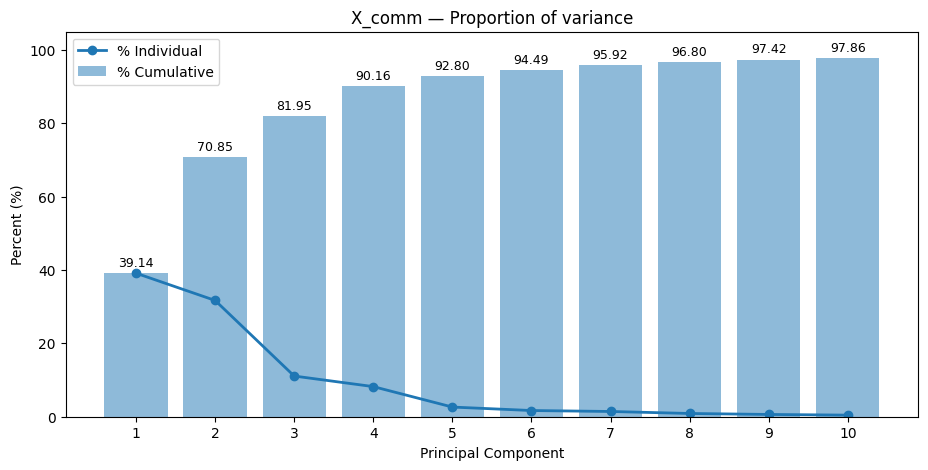

In [374]:
# Make dense if needed (PCA needs dense)
X_comm_dense = X_comm.toarray() if hasattr(X_comm, "toarray") else X_comm

# Fit PCA
pca_comm = PCA(random_state=RANDOM_STATE)
pca_comm.fit(X_comm_dense)

# Choose how many PCs to show (like your example: 10)
n_show = 10
var_ratio = pca_comm.explained_variance_ratio_[:n_show] * 100          # % individual
cum_ratio = np.cumsum(var_ratio)                                       # % cumulative

pcs = np.arange(1, n_show + 1)

plt.figure(figsize=(11, 5))

# Cumulative bars (grey)
plt.bar(pcs, cum_ratio, alpha=0.5, label="% Cumulative")

# Individual line (black) with markers
plt.plot(pcs, var_ratio, marker="o", linewidth=2, label="% Individual")

# Optional: label cumulative values on top of bars
for x, y in zip(pcs, cum_ratio):
    plt.text(x, y + 1, f"{y:.2f}", ha="center", va="bottom", fontsize=9)

# Titles + labels
plt.title("X_comm — Proportion of variance")
plt.xlabel("Principal Component")
plt.ylabel("Percent (%)")
plt.ylim(0, 105)
plt.xticks(pcs)
plt.legend()
plt.show()

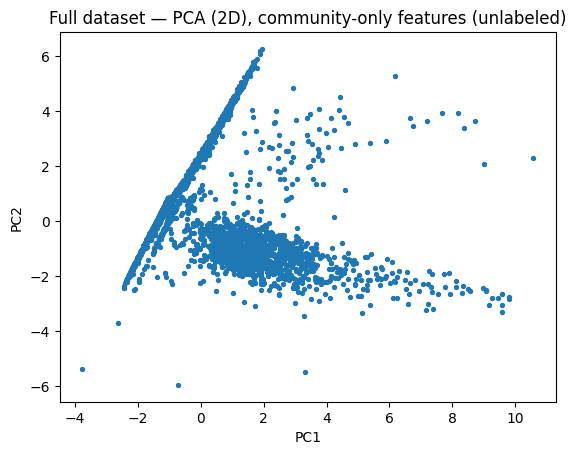

Explained variance ratio (PC1, PC2): [0.39141947 0.3171219  0.11094371 0.082153  ]
Total variance explained by PC1+PC2: 0.9016380780513652


In [370]:
# PCA 2D
# Some preprocess outputs are sparse; PCA works best on dense arrays
X_comm_dense = X_comm.toarray() if hasattr(X_comm, "toarray") else X_comm

pca2_comm = PCA(n_components=4, random_state=RANDOM_STATE)
X_comm_pca2 = pca2_comm.fit_transform(X_comm_dense)

plt.figure()
plt.scatter(X_comm_pca2[:, 0], X_comm_pca2[:, 1], s=8)
plt.title("Full dataset — PCA (2D), community-only features (unlabeled)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

print("Explained variance ratio (PC1, PC2):", pca2_comm.explained_variance_ratio_)
print("Total variance explained by PC1+PC2:", pca2_comm.explained_variance_ratio_.sum())

- For X_comm, the scree plot shows PC1 (\~39%) + PC2 (~32%) together capture about ~71% of the total variance, so a 2D PCA plot preserves most of the “big picture” structure while staying easy to visualize.
- After PC2, the marginal gain drops quickly (PC3 adds ~11%, PC4 ~8%), meaning additional components improve fidelity but don’t change the broad story as much.
- We used 2 components mainly because PCA is being used here as a simple visualization tool (not as the clustering input), and 2D is the clearest way to show patterns/outliers in one chart.
- If we wanted a slightly richer summary, 3 components is also reasonable (≈ 82% cumulative), but it requires a 3D plot or multiple 2D plots, which is harder to interpret in a report.

######*UMAP*

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


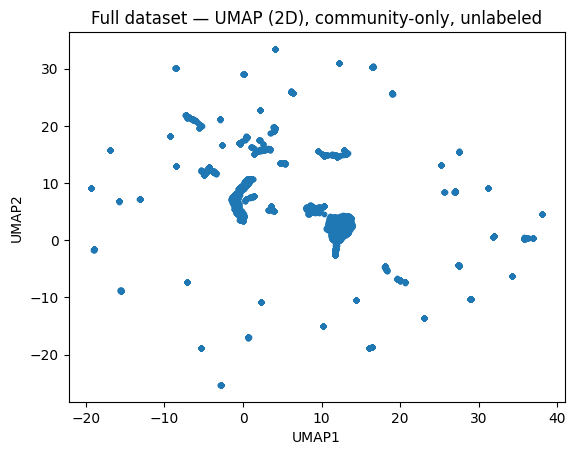

In [344]:
# UMAP 2D (for X_comm)
umap2_comm = umap.UMAP(
    n_neighbors=20,          # controls local vs global structure
    min_dist=0.05,           # lower -> tighter clusters in visualization
    n_components=2,
    random_state=RANDOM_STATE
)

# UMAP needs a dense array in some environments; handle safely
X_comm_dense = X_comm.toarray() if hasattr(X_comm, "toarray") else X_comm
X_comm_umap2 = umap2_comm.fit_transform(X_comm_dense)

plt.figure()
plt.scatter(X_comm_umap2[:, 0], X_comm_umap2[:, 1], s=10)
plt.title("Full dataset — UMAP (2D), community-only, unlabeled")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()

- The UMAP (X_comm) plot shows a dense central mass (many languages with very similar/low community signals) plus several separated “islands” and scattered outliers, which suggests the dataset has a big long tail and a few distinct popularity/adoption groups.
- We used UMAP over PCA because PCA is linear (it mainly captures one big gradient and can compress structure into a wedge/line), while UMAP is non-linear and is better at pulling apart local neighborhoods, making potential cluster structure easier to see visually.

#####*K Means Clustering on X_comm*

In [345]:
n = X_comm.shape[0]
sample_size = 1500 if n > 1500 else n

# Sample indices for silhouette (reproducible)
sample_idx = np.random.RandomState(RANDOM_STATE).choice(np.arange(n), size=sample_size, replace=False)

X_comm_sample = X_comm[sample_idx]

k_values_comm = list(range(2, 11))
sil_scores_comm = []

for k in k_values_comm:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(X_comm_sample)
    score = silhouette_score(X_comm_sample, labels)
    sil_scores_comm.append(score)

res_comm = pd.DataFrame({"k": k_values_comm, "silhouette_sample": sil_scores_comm})
res_comm

,k,silhouette_sample
0,2,0.367117
1,3,0.441627
2,4,0.456406
3,5,0.418907
4,6,0.384616
5,7,0.352035
6,8,0.341331
7,9,0.350841
8,10,0.353126


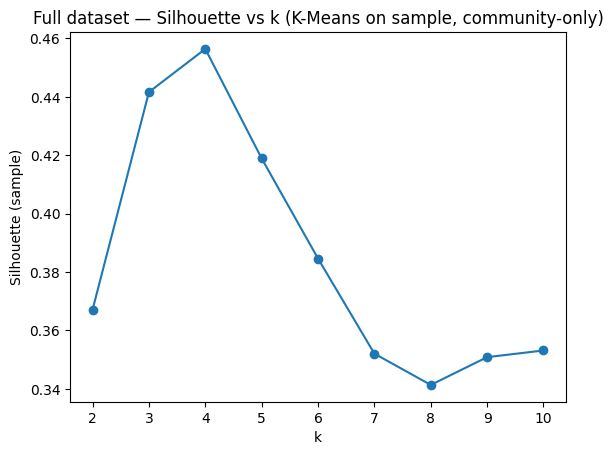

Best k (community-only): 4


In [346]:
# Plot silhouette on sample
plt.figure()
plt.plot(res_comm["k"], res_comm["silhouette_sample"], marker="o")
plt.title("Full dataset — Silhouette vs k (K-Means on sample, community-only)")
plt.xlabel("k")
plt.ylabel("Silhouette (sample)")
plt.show()

best_k_comm = int(res_comm.loc[res_comm["silhouette_sample"].idxmax(), "k"])
print("Best k (community-only):", best_k_comm)

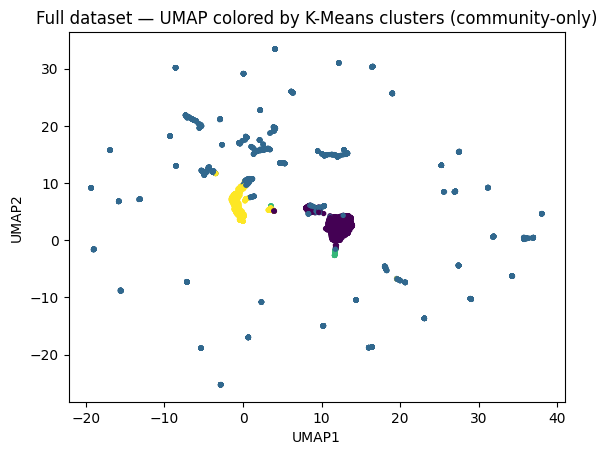

,title,cluster_kmeans_comm
0,Java,2
1,JavaScript,2
2,C,2
3,Python,2
4,SQL,2
5,C++,2
6,HTML,2
7,XML,2
8,PHP,2
9,Perl,2


In [347]:
kmeans_comm = KMeans(n_clusters=best_k_comm, random_state=RANDOM_STATE, n_init=10)
labels_km_comm = kmeans_comm.fit_predict(X_comm)

# Plot K-Means clusters on UMAP
plt.figure()
plt.scatter(X_comm_umap2[:, 0], X_comm_umap2[:, 1], c=labels_km_comm, s=8)
plt.title("Full dataset — UMAP colored by K-Means clusters (community-only)")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()

df_full_out = df_full.copy()
df_full_out["cluster_kmeans_comm"] = labels_km_comm

df_full_out[["title", "cluster_kmeans_comm"]].head(10)

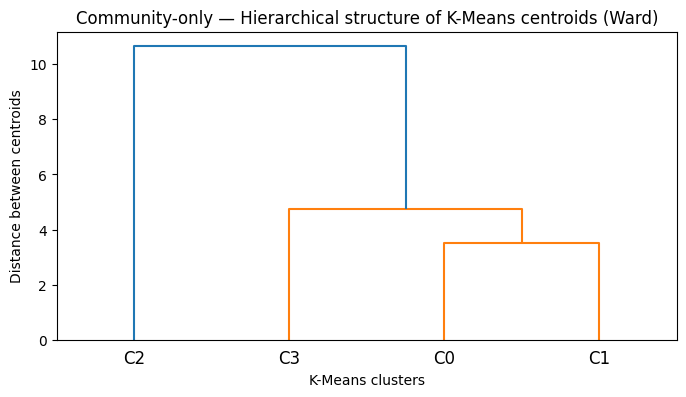

In [354]:
# Make sure kmeans_comm is already fitted
# kmeans_comm = KMeans(n_clusters=best_k_comm, random_state=RANDOM_STATE, n_init=10).fit(X_comm_dense)

centroids = kmeans_comm.cluster_centers_
Zc = linkage(centroids, method="ward")

plt.figure(figsize=(8, 4))
dendrogram(Zc, labels=[f"C{i}" for i in range(centroids.shape[0])])
plt.title("Community-only — Hierarchical structure of K-Means centroids (Ward)")
plt.xlabel("K-Means clusters")
plt.ylabel("Distance between centroids")
plt.show()

This dendrogram is showing the hierarchical relationships between 4 K-Means clusters’ centroids (so it’s comparing the clusters to each other, not individual languages).

- C0 and C1 merge first (lowest distance ~3–4) → these two clusters are the most similar in their community profiles (users/jobs/wiki/stars patterns are closest).

- C3 joins next (~5) → C3 is somewhat similar to the C0/C1 pair, but still meaningfully different.

- C2 joins only at a much larger distance (~10–11) → C2 is the most distinct / separated cluster compared to the other three, meaning its centroid has a very different community signal pattern (often this corresponds to the “mainstream/high-adoption” or “extreme” segment depending on your earlier median table).

#####*Interpreting the Clusters*

In [348]:
df_full_out["cluster_kmeans_comm"].value_counts().sort_index().to_frame("size")

,size
cluster_kmeans_comm,
0,1218
1,2308
2,80
3,697


In [349]:
# Cluster medians for key community metrics (log columns)
summary_comm_cols = ["appeared", "last_activity"] + log_cols_full
summary_comm_cols = [c for c in summary_comm_cols if c in df_full_out.columns]

cluster_comm_numeric = df_full_out.groupby("cluster_kmeans_comm")[summary_comm_cols].median().round(3)
cluster_comm_numeric


,appeared,last_activity,log1p_number_of_users,log1p_number_of_jobs,log1p_wikipedia_daily_page_views,log1p_wikipedia_backlinks_count,log1p_wikipedia_revision_count,log1p_github_repo_stars,log1p_github_repo_forks
cluster_kmeans_comm,,,,,,,,,
0,1992.0,2006.0,5.081,0.000,3.296,3.701,4.078,0.000,0.000
1,1994.0,1995.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,1995.0,2022.0,10.829,7.587,7.062,6.780,7.300,0.000,0.000
3,2015.0,2022.0,6.258,0.000,0.000,0.000,0.000,5.927,3.401


In [350]:
# Example languages per community cluster
for cl in sorted(df_full_out["cluster_kmeans_comm"].unique()):
    examples = sorted(df_full_out[df_full_out["cluster_kmeans_comm"] == cl]["title"].dropna().astype(str).unique())[:10]
    print(f"\nCommunity cluster {cl} examples ({len(examples)} shown):")
    print(examples)


Community cluster 0 examples (10 shown):
['.QL', '20-GATE', '3D Manufacturing Format', 'A#', 'A+', 'A++', 'ABC', 'ABC 80', 'ABSET', 'ACL2']

Community cluster 1 examples (10 shown):
['$', '*Prolog', '1.pak', '1C Enterprise Script', '2-pak', '2OBJ', '2lisp', '3-LISP', '3APL', '3D Logo']

Community cluster 2 examples (10 shown):
['ABAP', 'ARM', 'ASP', 'ActionScript', 'Ada', 'Arduino Programming Language', 'Assembly language', 'Bash', 'C', 'C#']

Community cluster 3 examples (10 shown):
['05AB1E', 'AIL', 'AIML', 'AL', 'API Blueprint', 'ASDF', 'ActivityPub', 'Adept', 'Aheui', 'Aith']


##**Findings / Discussion (M2)**

###**What I did in M2**

I built **two feature sets** to match my two sub-questions:

- **Feature Set A — Technical (`X_tech`)**
  - File-extension “fingerprint” (one-hot) + GitHub language metadata  
  - Includes time signals + log-transformed adoption signals  
  - Built only for languages that *actually list extensions*

- **Feature Set B — Community (`X_comm`)**
  - Community + popularity signals (users, jobs, Wikipedia, GitHub stars/forks) + time  
  - Built for the *full dataset*

For each feature set, I:
- handled missing values (**median** for numeric, **mode** for categorical)
- scaled numeric features (so no single metric dominates)
- ran **K-Means** and visualized structure using **PCA / UMAP**

For **Feature Set A**, I also ran **Agglomerative (Ward)** to compare methods.

###**Key observations (from my notebook outputs)**

#### **Data availability / limitations**
- Full dataset contains **4,303 languages**<br>

##### **Missingness snapshot (selected high-impact columns)**

| Column | Missing (count) | Missing (%) | What it affects |
|---|---:|---:|---|
| `github_repo_stars` | 3,414 / 4,303 | 79.34% | GitHub popularity signal |
| `wikipedia_daily_page_views` | 2,837 / 4,303 | 65.93% | Wikipedia attention signal |
| `number_of_jobs` | 2,538 / 4,303 | 58.98% | Market/job demand signal |
| `number_of_users` | 1,858 / 4,303 | 43.18% | Adoption/user-base signal |

<br>

##### **Technical coverage limitation**
| Column | Missing (count) | Missing (%) | Resulting usable rows |
|---|---:|---:|---:|
| `github_language_file_extensions` | 3,833 / 4,303 | 89.08% | **470 languages (10.92%)** |

<br>**Interpretation:** technical clustering is only meaningful for the **470 languages** that actually list extensions.

###**Answer to Sub-Question 1**

####**Technical clusters (extensions + GitHub metadata)**

#####***What clusters emerged?***
- K-Means selected **k = 5** for the technical subset  
- Cluster sizes: **[120, 196, 50, 103, 1]**  
  → The last cluster is a **single-language outlier**<br><br>

#####***How interpretable are they?***
- Clusters are *somewhat* interpretable, but extension one-hots are **sparse**
- A clear outlier is the **single-language cluster** (Cluster 4), which appears to be **XML**
- To explain each cluster, I rely on:
  - cluster size  
  - example languages  
  - top extension signals per cluster (when needed)<br><br>

#####***Do results look reasonable / stable?***
- **Method agreement:** K-Means vs Agglomerative (Ward) gives **ARI = 0.8112**  
  → strong consistency across two different methods
- **Sensitivity check (TOP_N_EXT):**
  - TOP_N_EXT = 40 vs base → **ARI = 0.8730**
  - TOP_N_EXT = 80 vs base → **ARI = 1.0000**
  → technical clustering is **not very sensitive** once a reasonable extension vocabulary is used<br><br>


###**Answer to Sub-Question 2**

####**Community clusters (GitHub / Wikipedia / users / jobs)**

#####***What clusters emerged?***
- K-Means selected **k = 4** for the community-only feature set  
- Cluster sizes: **[1218, 2308, 80, 697]**  
  → one cluster is very small but important (**80 languages**)<br><br>

#####***Do they reflect market segmentation?***
Yes — the clusters mostly reflect **adoption tiers + signal availability**:

- **Community Cluster 2 (size 80)** looks like the **mainstream / high-adoption segment**  
  Example languages include: **ABAP, Ada, Bash, C, C#**  
  Median log1p signals are much higher, e.g.:
  - `log1p_number_of_users ≈ 10.829`
  - `log1p_number_of_jobs ≈ 7.587`
  - `log1p_wikipedia_daily_page_views ≈ 7.062`

- **Community Cluster 1 (size 2308)** is the **long tail**  
  Many medians are **0**, which suggests very low activity or missing signals

- The remaining clusters represent “in-between” groups (moderate signals, or newer/active but not widely adopted)

###**What worked / what didn’t / what surprised me**

#####***Worked***
- Splitting Feature Set A vs B made interpretation much cleaner
- Log-transforming skewed variables prevented outliers from dominating distances
- K-Means + UMAP gave a clear visual sense of structure

#####***Didn’t work as well***  
- Extension clustering is limited because only **~11% of languages** list extensions, and extension one-hots are sparse
- Community clustering is influenced strongly by **missingness / zeros**, so I avoided over-interpreting the long tail

#####***Surprised me***
- Community clustering produced a **small but very clear “high-adoption” cluster (80 languages)**  
  while most languages fall into low/unknown activity groups

###**What has NOT been done yet**

- I have not done Sub-Question 3 (alignment/mismatch between technical and community clusters). I am saving it for a milestone 3.
- I also have not done deeper interpretability work like:
  - naming clusters using the strongest features  
  - analyzing which features drive cluster separation using centroid differences
  

###**Future methods / next milestones (simple plan)**

- **Cluster interpretation:** report example languages + median signals per cluster in plain English  
- **Optional alternative clustering:** try a density method (DBSCAN / HDBSCAN) on community features to see if it finds “core + outliers”  
- **Subquestion Q3:** compare technical vs community labels using ARI/crosstabs and highlight mismatches

###**Summary**


- Using community signals, languages naturally separate into a few **adoption tiers**:  
  a small mainstream/high-activity group and a large low-signal long tail.
- Technical clustering is possible, but it is limited because extension data is missing for most languages.
- Overall, the dataset supports the idea that languages cluster meaningfully — especially through community adoption signals.

##**GenAI Appendix**

I used GenAI support in a limited way for:
- **Concept checks** (e.g., what ARI means, why we log-transform skewed variables, and what PCA vs UMAP is used for),
- **Debugging small code errors** (example: fixing `RANDOM_STATE` not defined, and handling sparse vs dense matrices),
- **Wording help** for a few short explanations.

All dataset cleaning, feature engineering, model runs, plots, and interpretations in this notebook were implemented and verified by me.